In [283]:
import numpy as np
import scipy.optimize as optimize
import scipy.stats as st
import enum 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate


from numpy.random import Generator, PCG64
import time
plt.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

from scipy.stats import norm
from joblib import Parallel, delayed

In [ ]:
#%% V_zcb, modified from git 

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def HW_theta(lambd,eta,P0T): # derived from instantaneous forward rate,
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t)) # Or choose theta ourselves??
    return theta#lambda t: 0.1+t-t
    
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_Mu_FrwdMeasure(P0T,lambd,eta,T): #? 
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001) # Byta ut från simulation? 0.03
    theta = HW_theta(lambd,eta,P0T)
    zGrid = np.linspace(0.0,T,500)
    
    theta_hat =lambda t,T:  theta(t) + eta*eta / lambd *1.0/lambd * (np.exp(-lambd*(T-t))-1.0)
    
    temp =lambda z: theta_hat(z,T) * np.exp(-lambd*(T-z))
    
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid),zGrid)
    
    return r_mean

def HWVar_r(lambd,eta,T):
    return eta*eta/(2.0*lambd) *( 1.0-np.exp(-2.0*lambd *T))

def HW_ZCB_CallPutPrice(CP,K,lambd,eta,P0T,T1,T2):
    B_r = HW_B(lambd,eta,T1,T2)
    A_r = HW_A(lambd,eta,P0T,T1,T2)
    
    mu_r = HW_Mu_FrwdMeasure(P0T,lambd,eta,T1)
    v_r =  np.sqrt(HWVar_r(lambd,eta,T1))
    
    K_hat = K * np.exp(-A_r)
    
    a = (np.log(K_hat) - B_r*mu_r)/(B_r*v_r)
    
    d1 = a - B_r*v_r
    d2 = d1 +  B_r*v_r
    
    term1 = np.exp(0.5* B_r*B_r*v_r*v_r + B_r*mu_r)*st.norm.cdf(d1) - K_hat * st.norm.cdf(d2) 

    value =P0T(T1) * np.exp(A_r) * term1 
    
    if CP == OptionType.CALL:
        return value
    elif CP==OptionType.PUT:
        return value - P0T(T2) + K*P0T(T1)
    

# Swaptions using Jamshidian’s trick
def solve_r_star(lambd, eta, P0T, cashflows, Tm, payment_dates):
    """
    Solve for r_star such that sum of discounted cashflows equals 1.
    """
    def objective(r_star):
        sum_terms = sum(
            c * np.exp(HW_A(lambd, eta, P0T, Tm, Tk) + HW_B(lambd,eta, Tm, Tk) * r_star)
            for c, Tk in zip(cashflows, payment_dates)
        )
        return 1 - sum_terms  # The equation to solve

    r_star = optimize.newton(objective, 0.0)  # Solve for r_star using Newton's method, brentq?
    return r_star

def price_swaption(CP, lambd, eta, P0T, Tm, Tn, notional, cs = 0.02):
    payment_dates = np.arange(Tm + 1,Tm + Tn + 1, dtype= int)
    cashflows = np.full(len(payment_dates), cs)  # Create annual cashflows
    cashflows[-1] += 1  # last payment includes notional

    r_star = solve_r_star(lambd, eta, P0T, cashflows, Tm, payment_dates)

    K_values = [
        np.exp(HW_A(lambd, eta, P0T, Tm, Tk) + HW_B(lambd,eta, Tm, Tk) * r_star)
        for Tk in payment_dates
    ]

    swaption_price = notional* sum(
        c * HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, Tm, Tk)
        for c, K, Tk in zip(cashflows, K_values, payment_dates)
    )

    return swaption_price

### Some imports and generating an interest rate / intensity time series

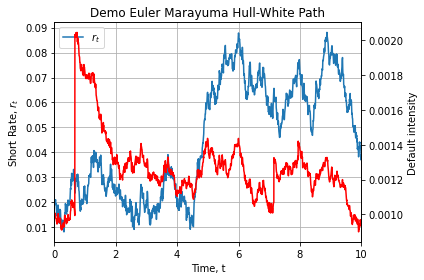

Correlation of output rho = 0.8: -0.06846637753347289 


In [288]:
# Set parameters, for clarity those related to the JCIR model will be preceded by a J and those related to the Hull white by an H
t0 = 0
T = 10

# Intensity params
lambda0 = 0.001
mu = 0.001
kappa = 0.5
v = 0.005

j_alpha = 4/T # We should expect to see about 4 jumps,
gamma = mu/5 # With expected size mu/5

# Short rate params
r0 = 0.02
theta = r0*(1/2)
alpha = 1/4
sigma = r0

rand = Generator(PCG64())

## Generate Jumps for the JCIR
jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run rho 0.8 diffusion model for let's say 1280 time steps over our 10 time units, i.e. dt = 1/128
N = T*128
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0, lambda0,len(t_s))
r = np.linspace(r0, r0,len(t_s))

# We could (should?) use Cholesky decomposition to covary the noise as well, but since multivariate_normal let's us generate correlated noise why not let it take care of it for us
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0.8
gen_noise = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s)))
Z_gen = gen_noise[:,0]
W_gen = gen_noise[:,1]



for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]
    dZ = np.sqrt(dt)*Z_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (theta-alpha*r[i-1])*dt + sigma*dW

    # Generate JCIR
    a = ((4*kappa*mu - v**2)*Y_s[i-1]**(-1) - (4*kappa)*Y_s[i-1])/8
    ap = (-(4*kappa*mu - v**2)*Y_s[i-1]**(-2) - (4*kappa))/8
    app = (4*kappa*mu - v**2)*Y_s[i-1]**(-3)/4
    b = (1/2)*v
    Y_s[i] = Y_s[i-1] + a*dt + b*dZ + (1/2)*(a*ap - (1/2)*app*b**2)*dt**2 + (1/2)*(ap*b)*dZ*dt
    lambdas[i] = Y_s[i]**2

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            Y_s[i] = np.sqrt(lambdas[i])
            jumps.pop(0)

    # Emergency negative catch
    if Y_s[i] < 0:
        Y_s[i] = 0
    

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,r,label = r"$r_t$")
ax2 = ax1.twinx()
ax2.plot(t_s, lambdas, label = r"$\lambda_t$", color = "red")
ax2.set_ylabel("Default intensity")
ax1.set_title("Demo Euler Marayuma Hull-White Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Short Rate, $r_t$")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()
print(r"Correlation of output rho = %s" %(rho1) + ": %s " %(np.corrcoef((lambdas,r))[0][1]))

### Pricing Swaptions Semi-Analytically
What is written below is based almost entirely on the Lecture slides created by [Grezlak](https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/tree/main), specifically lectures 4, 5 and 7. (We have this in the projektplan)

We're operating under the Hull-White model 
$$dr_t = (\theta - \alpha r_t)dt + \sigma_t dW_t$$
assuming constant variance $\sigma$ (to begin with) we can price the European Swaption with nominal N as (Magnus Slides)
$$N\cdot\mathrm{P}(t_0, T_m)\sum_{k = m+1}^{n}c_kV_{T_m,T_k}^{\mathrm{ZCB}}(t_0,\hat{K},-1)$$
with
$$\hat{K} = e^{A + B\cdot r^*}$$
and $c_k$, $r^*$ chosen such that
$$1 - \sum_{k = m+1}^{n}c_k \mathrm{exp}\left(A(T_m,T_k) + B(T_m,T_k)r^*\right) = 0 \\
c_k = K \tau_k ~ \forall (k \in \{m+1,...,n-1\}) \\
c_n = K(1 + \tau_n)$$
and the functions + price of ZCB
$$A(t,T) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (T-t)} - 4e^{-\alpha (T-t)} - 2\alpha (T-t) \right) + \alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz$$
$$B(t,T) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(T-t)} \right) $$
$$P(t,T) = \mathrm{exp}(A(t,T) + B(t,T)r(t)) $$
we can solve the integral analytically for fixed $\alpha$ and $\theta$
$$\alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz = -\frac{\theta}{\alpha}\int_{t}^{T}1 - e^{-\alpha T} e^{\alpha z}dz \\
= -\frac{\theta}{\alpha}[z - \frac{1}{\alpha}e^{-\alpha T}e^{\alpha z}]_{t}^{T} = \frac{\theta}{\alpha}\left((T-t) - \frac{1}{\alpha}(1 - e^{-\alpha(T - t)})\right)$$
So we can rephrase $A(t,T) = [\tau = T - t] = A(\tau)$ and $B(t,T) = B(\tau)$ as
$$A(\tau) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (\tau)} - 4e^{-\alpha (\tau)} - 2\alpha (\tau) \right) - \frac{\theta}{\alpha}\left((\tau) - \frac{1}{\alpha}(1 - e^{-\alpha(\tau)})\right)$$
$$B(\tau) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(\tau)} \right)$$
We can price the ZCB put option as 
$$V_c^{\mathrm{ZCB}}(t_0,T) = P(t_0,T) e^{A(\tau)}\left[\mathrm{exp}(\frac{1}{2}B(\tau)^2v_r^2(t_0,T) + B(\tau)\mu_r(t_0,T))\mathit{F}_{\mathcal{N}(0,1)}(\mathit{d_1}) - \hat{K}_2\mathit{F}_{\mathcal{N}(0,1)}(d_2) \right]\\
d_1 = a - B(\tau)v_r(t_0,T),~~d_2 = d_1 + B(\tau)v_r(t_0,T), ~~ \hat{K}_2 = Ke^{-A(\tau)} \\
a = \frac{log(\hat{K}_2 - B(\tau)\mu(t_0,T))}{B(\tau)v_r(t_0,T)} \\
\mu(t_0,T) = r_0e^{-\alpha(T-t_0)} + \alpha\int_{t_0}^T\hat{\frac{\theta(z,T)}{\alpha}}e^{-\alpha(T-z)}dz \\
= \left[\hat{\theta} = \theta + \frac{\sigma^2}{\alpha^2}(e^{-\alpha(T-t)} -1)\right] \\
= [\theta~\mathrm{ const}] = r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\tau}) + \frac{\sigma^2}{\alpha}\int_{t_0}^T e^{-2\alpha(T-z)} - e^{-\alpha(T-z)}dz \\
= r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\tau}) + \frac{\sigma^2}{\alpha}\left(\frac{-1}{2\alpha}[e^{-2\alpha(T-z)}]^T_{t_0} + \frac{1}{\alpha}[e^{-\alpha(T-z)}]_{t_0}^T \right) \\
= r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\tau}) + \frac{\sigma^2}{\alpha}\left(\frac{-1}{2\alpha}(1 - e^{-2\alpha(T-t_0)}) + \frac{1}{\alpha}(1 - e^{-\alpha(T-t_0)}) \right) \\
 v_r^2(t_0,T) = \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha(T-t_0)})$$

with all this legwork done we have a cumbersome but almost explicit (explicit once you've found $r^*$) expression for the value of an option constant parameter Hull-White.


In [290]:
# General functions
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) - (theta/alpha)*((T-t) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
Khat = lambda t,T, rstar: np.e**(A(t,T) + B(t,T)*rstar)
P = lambda t,T,rt: np.e**(A(t,T)+B(t,T)*rt)

# Put on ZCB functions
Khat2 = lambda t,T, K: K*np.e**(-A(t,T))
Fn = lambda arg: norm.cdf(arg)
mu_v = lambda t, T, r0: r0*np.e**(-alpha*(T - t)) - (theta/alpha)*(1 - np.e**(-(T - t))) + (sigma**2 / alpha)*((-1/(2*alpha))*(1 - np.e**(-2*alpha*(T-t))) + (1/alpha)*(1 - np.e**(-alpha*(T-t))))
v_r2 = lambda t,T: (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
a = lambda t,T ,K, r0: (np.log(Khat2(t,T,K) - B(t,T)*mu_v(t,T,r0)))/(B(t,T)*(v_r2(t,T))**(1/2))

d1 = lambda t,T,K,r0: a(t,T,K,r0) - B(t,T)*(v_r2(t,T)**(1/2))

d2 = lambda t,T,K,r0: d1(t,T,K,r0) + B(t,T)*(v_r2(t,T)**(1/2))

VZCB_call = lambda t,T,K,rt: P(t,T,rt)*np.e**(A(t,T))* ( np.e**(1/2 * B(t,T)**2 * v_r2(t,T) + B(t,T)*mu_v(t,T,rt))*Fn(d1(t,T,K,r0)) - Khat2(t,T,K)*Fn(d2(t,T,K,rt)))

VZCB_put = lambda t, T, K, rt: VZCB_call(t, T, K, rt) - P(T,T, rt) + K*P(t, T, rt)
# c_k from schedule
cashflows = lambda K, Ts: (K*np.diff(Ts) + np.concatenate((np.zeros((1,len(Ts)-2)), np.asmatrix(1)),1)).A1

# Solve for rstar
minimize = lambda cashflows, dates, Tm, rstar: 1 - sum([c*np.e**(A(Tm,date) + B(Tm,date)*rstar) for c, date in zip(cashflows,dates)])
def rstar(cashflows, dates, Tm):
    optim = lambda rstarl: minimize(cashflows, dates, Tm, rstarl)
    return optimize.newton(optim, 0, rtol=1e-3, tol = 1e-6)

# Solve for Swaption with nominal 1
def swaption_price(t, rt, T_s, K):
    T_m = T_s[0] # The entrance date
    dates = T_s[1:] # The payment dates
    cashs = cashflows(K, T_s) # The Cashflows
    rst = rstar(cashs, dates, T_m) # Rstar
    value = P(t,T_m,rt)*(sum([c*VZCB_call(T_m, Tk, Khat(T_m,Tk,rst), rt) for c, Tk in list(zip(cashs,dates))]))
    return value



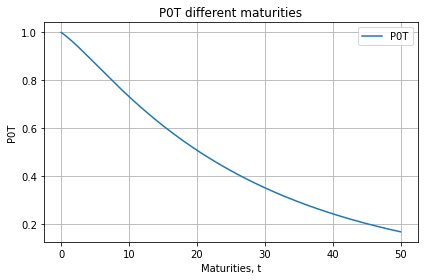

In [268]:
T_s = np.arange(10.01,21.01,1)
P0T = np.zeros(len(t_s))
for i in np.arange(0,len(t_s)):
    P0T[i] = P(t_s[0],t_s[i],r[0])

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,P0T,label = "P0T")
ax1.set_title("P0T different maturities")
ax1.set_xlabel("Maturities, t")
ax1.set_ylabel("P0T")
#ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()

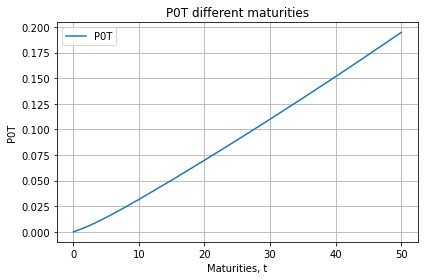

In [281]:
yield_curve = lambda p, y: ((1/p)**(1/y)-1)

T_s = np.arange(10.01,21.01,1)
P0T = np.zeros(len(t_s))
yc = np.zeros(len(t_s))
for i in np.arange(0,len(t_s)):
    P0T[i] = P(t_s[0],t_s[i],r[0])
    yc[i] = yield_curve(P0T[i],10)

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,yc,label = "P0T")
ax1.set_title("P0T different maturities")
ax1.set_xlabel("Maturities, t")
ax1.set_ylabel("P0T")
#ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()


/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_31490/2305686771.py:12: RuntimeWarning: invalid value encountered in log
  a = lambda t,T ,K, r0: (np.log(Khat2(t,T,K) - B(t,T)*mu_v(t,T,r0)))/(B(t,T)*(v_r2(t,T))**(1/2))


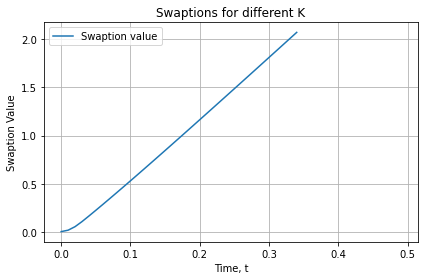

In [264]:
# There is clearly something wrong with my implementation above :.(

T_s = np.arange(10.01,21.01,1)
Fixed = np.arange(0,0.5,0.01)
swap_prices = np.zeros((len(Fixed),1))

for i in np.arange(0,len(Fixed)-1):
    swap_prices[i] = swaption_price(t_s[0],r[0], T_s, Fixed[i])

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(Fixed,swap_prices,label = "Swaption value")
ax1.set_title("Swaptions for different K")
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
# ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()

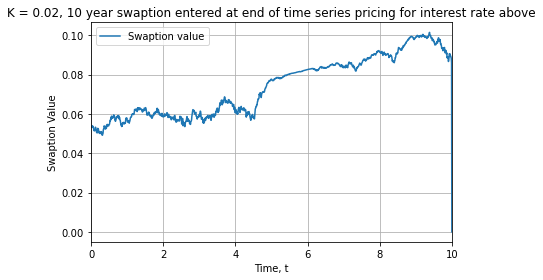

In [291]:
# There is clearly something wrong with my implementation above :.(

T_s = np.arange(10.01,21.01,1)
Fixed = 0.02
swap_prices = np.zeros((len(t_s),1))

for i in np.arange(0,len(t_s)-1):
    swap_prices[i] = swaption_price(t_s[i],r[i], T_s, Fixed)

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,swap_prices,label = "Swaption value")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %Fixed)
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()

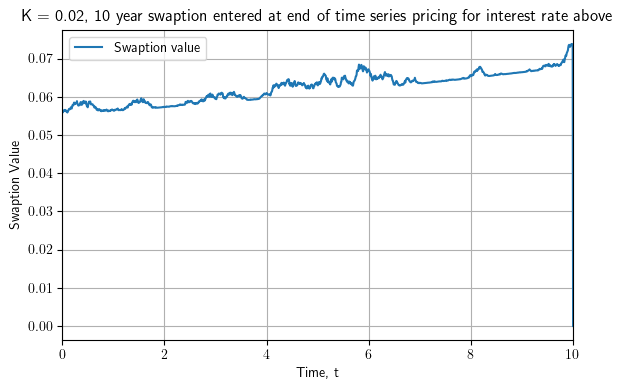

In [ ]:
# There is clearly something wrong with my implementation above :.(

T_s = np.arange(10.01,21.01,1)
Fixed = 0.02
swap_prices = np.zeros((len(t_s),1))

for i in np.arange(0,len(t_s)-1):
    swap_prices[i] = swaption_price(t_s[i],r[i], T_s, Fixed)

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,swap_prices,label = "Swaption value")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %Fixed)
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend()
plt.show()


### Monte Carlo Pricing of Swaptions
The difficulty in pricing a european swaption comes from the unkown value of the swaption at the entry. Given the market state at entry the value of the swap and thus the option is clear. By using monte-carlo to find a distribution of option values at entry we can find the option values in a way with much less analytic work and as such less room for confusion, but at potentially increased computational cost or increased variance.

#### The value of a swap under Hull-White
The value of a swap is simply the summation of the value of each legs floating minus each legs fix. Since we don't know future interest raets we use the future libor rate, which is the same as the 
$$V_{m,n}^{\mathrm{Swap}}(t_0) = [P(t_0,T_m)-P(t_0,T_n)] - K\sum_{k=m+1}^{n}\tau_k P(t_0,T_k)$$
Where the first term, in square brackets, gives the value of the floating leg, and the summation gives the fixed leg. In the section on Semi-Analytic pricing we present an unambigous and (lightly tested by me) formula for the value of the ZCB discount factor $P(t_0,T)$

Then we need to draw market positions at the entry point for the contract. Since our market model is markov we only actually need the interest rate at T. Under Hull-White the distribution of the interest rate (using Vasicek here since I'm setting everything constant for now, but this distriution is very similar even under time varying variance (I think), but sigma moves into an integral) is known to be normal (See e.g. wikipedia) with mean 
$$\hat{\mu}_t = e^{-\alpha(t - t_0)}r(t_0) + \frac{\theta}{\alpha}(1 - e^{-\alpha(t-t_0)})$$
and variance
$$\hat{\sigma}^2_t = \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha (t - t_0)})$$

So we can draw these market states at entry very efficiently from current market states.

### Demonstration of from t = 0, single point pricing with no variance reduction techniques

In [292]:
# Bring in the P function so that it's running on the latest information
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) - (theta/alpha)*((T-t) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
P = lambda t,T,rt: np.e**(A(t,T)+B(t,T)*rt)

# Find our intitial state and the underlying swap schedule
r0 = r0
t = 0

T_s = np.arange(10,21,1)
T = T_s[0]
K = 0.02

durations = np.diff(T_s)
payment_dates = T_s[1:]

# Find the parameters of the future short rate distribution
mu_hat = np.e**(-alpha*(T - t))*r0 + (theta/alpha)*( 1- np.e**(-alpha*(T-t)))
sigma_hat_2 = (sigma**2 /2*alpha)*(1 - np.e**(-2*alpha*(T-t)))

# Generate future short rate 
N_samples = 1000
mkt_samples = rand.normal(mu_hat,sigma_hat_2**(1/2), (N_samples,1))

# Check future short rate sample quality
print("--- Check that the mean and variance are as we want ---")
print("Desired Mean: %s" %(mu_hat))
print("Sample ean: %s" %(np.mean(mkt_samples)))
print("Desired Variance: %s" %sigma_hat_2)
print("Sample Variance : %s" %np.var(mkt_samples,ddof = 1))
print("Looks Good To Me")

# Generate future swap prices from short rate, remember, we've advanced the market to t = T = T_m, ie at the entry
# P(j,j) = 1, but I leave it as P to make it easier to connect to the equation
# T_s[-1] is the last time and therefore T_n
Swap_Val_entry = lambda rT, durations, K: (P(T,T, rT) - P(T,T_s[-1],rT)) - K*sum([tau*P(T,T_k,rT) for tau, T_k in zip(durations, payment_dates)])
swap_samples = [Swap_Val_entry(x, durations, K) for x in mkt_samples]

# Find the Swaption values from the swap values
swaption_samples = [x*(x>0) for x in swap_samples]

# Take mean and discount to time t0
value = P(t,T,r0)*np.mean(swaption_samples)

print("0.02 Strike, Unit Swaption value at t = 0: %s" %value)
print("Estimated Std Dev of estimate: %s" %(np.var(swaption_samples, ddof = 1)**(1/2) / (N_samples**(1/2))))

print("--- After running this with more samples I get the value of this swaption to be 0.00507  ---")

--- Check that the mean and variance are as we want ---
Desired Mean: 0.038358300027522024
Sample ean: 0.0383537479116521
Desired Variance: 4.9663102650045726e-05
Sample Variance : 5.1088591656395334e-05
Looks Good To Me
0.02 Strike, Unit Swaption value at t = 0: 0.11140539692091589
Estimated Std Dev of estimate: 0.0006646466357442284
--- After running this with more samples I get the value of this swaption to be 0.00507  ---


### For all time points produced by a run of the interest rate model


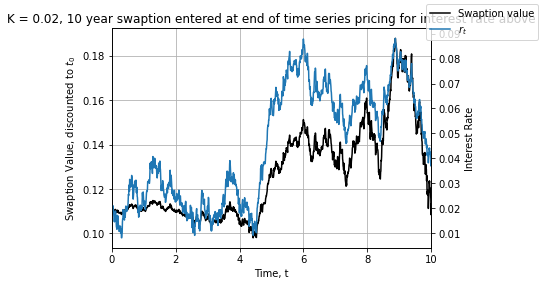

In [293]:
# Set up the Swap params
K = 0.02
T_s = np.arange(10,21,1)
T = T_s[0]
durations = np.diff(T_s)
payment_dates = T_s[1:]

# Set up pricing and mean/var functions
mu_hat = lambda T, t, rt: np.e**(-alpha*(T - t))*rt + (theta/alpha)*( 1- np.e**(-alpha*(T-t)))
sigma_hat_2 = lambda T, t: (sigma**2 /2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
Swap_Val_entry = lambda rT, durations, K: (P(T,T, rT) - P(T,T_s[-1],rT)) - K*sum([tau*P(T,T_k,rT) for tau, T_k in zip(durations, payment_dates)])

# Prep lists for results
end_val = np.zeros((len(t_s),1))
init_val = end_val
local_val = end_val

# Slightly lower sample count, it's noisier but runtime demands it, once I add var reduction techniques it should be fine?
N_samples = 500

# Run (Parallelized since there's no cross talk, we could parallelize lower level stuff but I think it's more intuitive to do it at as a high a level as possible)
# I also just chose the seemingly simplest way to parallelize from the first thread I  found, but it seems to work? https://stackoverflow.com/questions/9786102/how-do-i-parallelize-a-simple-python-loop
def process(i):
    # Get Time and interest rate
    curr_t = t_s[i]
    curr_r = r[i]

    # Find future swaption value distribution
    mkt_samples = rand.normal(mu_hat(T,curr_t,curr_r),sigma_hat_2(T,curr_t)**(1/2), (N_samples,1))
    swap_samples = swap_samples = [Swap_Val_entry(x, durations, K) for x in mkt_samples]
    swaption_samples = [x*(x>0) for x in swap_samples]

    # Find mean, and discount to local/initial value
    end_val = np.mean(swaption_samples)
    init_val = P(t,T,r0)*end_val
    
    return  init_val

# I set njobs to 4 since I have an old cpu from before thread count was the big thing, you might be able to get better results turning that up or down
init_val = Parallel(n_jobs = 4)(delayed(process)(i) for  i in range(len(r)))


# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,init_val,label = "Swaption value", color = "black")
ax2 = ax1.twinx()
ax2.plot(t_s,r,label = r"$r_t$")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, discounted to $t_0$")
ax1.set_xlim((t0,T))
ax1.grid(True)
fig1.legend()
plt.show()

### A concern about the method above
I do have one concern about discounting. I am confident in that we are finding a reasonable estimate of $\mathbb{E}^Q[(V^{Swap}(T_m))^+ | \mathcal{F}_t]$. But since what we're looking for is actually $\mathbb{E}^Q[\mathrm{Discounted~to~t~}((V^{Swap}(T_m))^+) | \mathcal{F}_t]$ is the discount really the deterministic $P(t,T_m)$, it feels like it should be but it also feels strange because that means that the actual future value of the money that is correlated to $r(T_m)$ is ignored. I think this is just me getting worked up in circles because I'm tired but if I get a chance I'll ask Magnus about it. Nonetheless the effects should be very small, and the swaption value will be a good approximation.

### Finding Q from gamma
Given that we are using JCIR as presented in Brigos book on CVA we have a closed form solution for the probability of default by T. 
$$\mathbb{Q}(\tau > T) = 1_{\tau > t}\hat{\alpha}(t,T)\mathrm{exp}(-\hat{\beta}(t,T)\lambda_t)$$
$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$
$$\hat{\alpha}(t,T) = A_{\mathrm{CIR}}(t,T)\left(\frac{2h \mathrm{exp}(\frac{h + \kappa + 2\gamma}{2}(T-t))}{2h + (\kappa + h + 2\gamma)(\mathrm{exp}(h(T-t)) -1)} \right)^{\frac{2\alpha \gamma}{v^2 - 2\kappa \gamma - 2\gamma^2}}$$
$$\hat{\beta}(t,T) = B(t,T) $$
$$A_{\mathrm{CIR}}(t,T) = \left[\frac{2h\mathrm{exp}\{(\kappa+h)(T-t)/2\}}{2h + (\kappa + h)(\mathrm{exp}\left\{(T-t)h\right\} -1)}\right]^{2\kappa\mu/\sigma^2}$$
$$B_{\mathrm{CIR}}(t,T) = \frac{2(\mathrm{exp}\{(T-t)h\}-1)}{2h + (\kappa+h)(\mathrm{exp}\{(T-t)h\}-1)}$$
$$h = \sqrt{\kappa^2 + 2v^2}$$

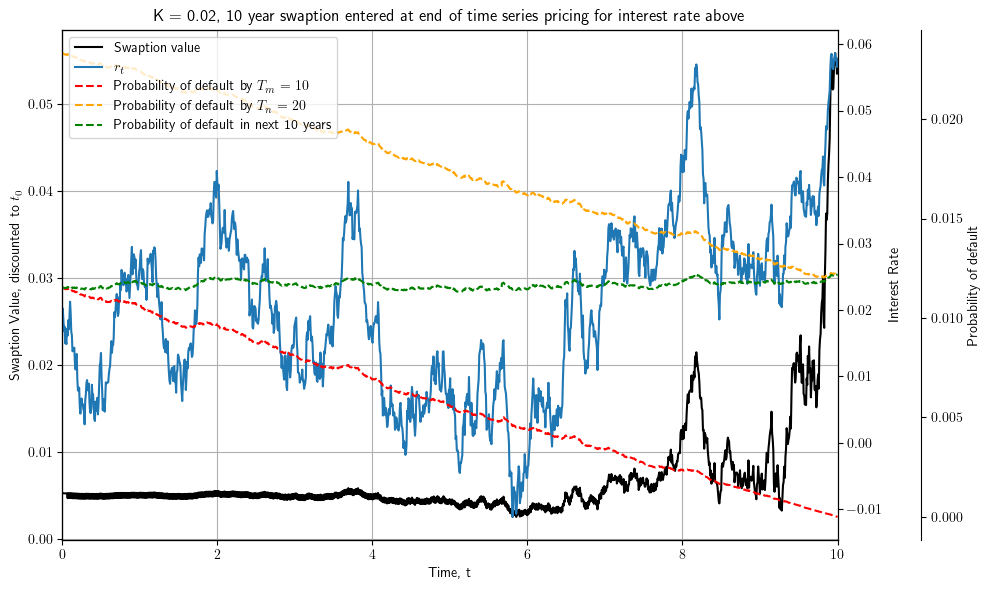

Correlation of default probability in next 10 years with swaption value: 0.5151618021656222


In [ ]:
# Defining functions bottom up
h = (kappa**2 + 2*v**2)**(1/2)
B_cir = lambda t,T: (2*(np.exp((T-t)*h)-1))/(2*h + (kappa + h)*(np.exp((T-t)*h)-1))
A_cir = lambda t,T: ((2*h*np.exp((kappa + h)*(T - t)/2))/(2*h + (kappa + h)*(np.exp((T-t)*h) -1)))**(2*kappa*mu/(v**2))
beta_hat = lambda t,T: B_cir(t,T)
alpha_hat = lambda t,T: A_cir(t,T)*((2*h*np.exp((h + kappa + 2*gamma)/(2) * (T-t)))/(2*h + (kappa + h + 2*gamma)*(np.exp(h*(T-t))-1)))**((2*alpha*gamma)/(v**2 - 2*kappa*gamma - 2*gamma**2))
Q = lambda t,T,lambd: alpha_hat(t,T)*np.exp(-beta_hat(t,T)*lambd)

# Find for instance Q(tau > T), ie the probability that we get to t = 10 at least
def_by_10 = np.linspace(0, 0,len(t_s))
def_by_20 = np.linspace(0, 0,len(t_s))
def_in_next_10 = np.linspace(0, 0,len(t_s))
for i in np.arange(0,len(t_s)):
    def_by_10[i] = Q(t_s[i], 10, lambdas[i])
    def_by_20[i] = Q(t_s[i], 20, lambdas[i])
    def_in_next_10[i] = Q(t_s[i], 10 + t_s[i], lambdas[i])

# Make a plot with the interest rate, default probability by T = 10 and the Swaption value all plotted together
# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (10,6), tight_layout = True)
p1 = ax1.plot(t_s,init_val,label = "Swaption value", color = "black")
ax2 = ax1.twinx()
ax3 = ax1.twinx()
p3 = ax3.plot(t_s, 1-def_by_10, label = r"Probability of default by $T_m = 10$" ,color = "red", linestyle = "--")
p4 = ax3.plot(t_s, 1-def_by_20, label = r"Probability of default by $T_n = 20$" ,color = "orange", linestyle = "--")
p5 = ax3.plot(t_s, 1-def_in_next_10, label = "Probability of default in next 10 years" ,color = "green", linestyle = "--")
p2 = ax2.plot(t_s,r,label = r"$r_t$")
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("Probability of default")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, discounted to $t_0$")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax3.legend(handles=p1+p2+p3+p4+p5,fancybox = True, framealpha = 0.8, loc = "upper left")
plt.show()

print("Correlation of default probability in next 10 years with swaption value: %s" %(np.corrcoef((1-def_in_next_10,init_val))[0][1]))



10.0
